### Preparation

#### loading

In [1]:
rm(list=ls());gc()
library(lubridate)
library(bigrquery)
library(tidyverse)
library(data.table)
library(ggplot2)
library(patchwork)
## BigQuery setup.
BILLING_PROJECT_ID <- Sys.getenv('GOOGLE_PROJECT')
# Get the BigQuery curated dataset for the current workspace context.
CDR <- Sys.getenv('WORKSPACE_CDR')

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,648076,34.7,1443041,77.1,1105655,59.1
Vcells,1203633,9.2,8388608,64.0,1924584,14.7



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr   1.1.4     ✔ readr   2.1.5
✔ forcats 1.0.0     ✔ stringr 1.5.1
✔ ggplot2 3.4.4     ✔ tibble  3.2.1
✔ purrr   1.0.2     ✔ tidyr   1.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ purrr::%||%()   masks base::%||%()
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year




In [2]:
sessionInfo()

R version 4.4.0 (2024-04-24)
Platform: x86_64-pc-linux-gnu
Running under: Ubuntu 20.04.6 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas-pthread/libblas.so.3 
LAPACK: /usr/lib/x86_64-linux-gnu/openblas-pthread/liblapack.so.3;  LAPACK version 3.9.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: Etc/UTC
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] patchwork_1.2.0   data.table_1.15.4 forcats_1.0.0     stringr_1.5.1    
 [5] dplyr_1.1.4       purrr_1.0.2       readr_2.1.5       tidyr_1.3.0      
 [9] tibble_3.2.1      ggplot2_3.4.

#### confidence interval function

In [3]:
CI<-function(p,n){
    err<-sqrt(p*(1-p)/n)*1.96
    paste0('[',paste(signif(c(p-err,p+err),2),collapse = ', '),']')
}

### find out the number of participants with specific medical conditions, excluding non-cisgender people

#### Exclude non-cisgender

In [4]:
all_person_df <- bq_table_download(bq_project_query(
    BILLING_PROJECT_ID, page_size = 25000,
    query = str_glue('
SELECT 
    person_id,sex_at_birth_source_value,gender_source_value
FROM {CDR}.person
')))
setDT(all_person_df)
cat(paste(nrow(all_person_df),
         "participants with survey data available\n"))
cat(paste(nrow(all_person_df[sex_at_birth_source_value%in%c('SexAtBirth_Male','SexAtBirth_Female')]),
         "participants with binary sex at birth"))

413457 participants with survey data available
404734 participants with binary sex at birth

In [5]:
# define non-cis-gender participants
all_person_df[!((sex_at_birth_source_value=='SexAtBirth_Male' & gender_source_value=='GenderIdentity_Man')|
         (sex_at_birth_source_value=='SexAtBirth_Female' & gender_source_value=='GenderIdentity_Woman')),noncisgender:=T]
all_person_df[is.na(noncisgender),noncisgender:=F]

In [6]:
all_person_df[,.N,by=noncisgender]

noncisgender,N
<lgl>,<int>
TRUE,16233
FALSE,397224


In [7]:
# breakdown of cisgender participants
all_person_df[which(!noncisgender),.N,by=sex_at_birth_source_value]

sex_at_birth_source_value,N
<chr>,<int>
SexAtBirth_Male,152093
SexAtBirth_Female,245131


In [8]:
# breakdown of noncisgender participants
noncisgender_person_df<-all_person_df[which(noncisgender)]
noncisgender_person_df[,.N,by=sex_at_birth_source_value][order(-N)]

sex_at_birth_source_value,N
<chr>,<int>
SexAtBirth_Female,4434
No matching concept,4284
PMI_Skip,3855
SexAtBirth_Male,3076
PMI_PreferNotToAnswer,346
SexAtBirth_SexAtBirthNoneOfThese,146
SexAtBirth_Intersex,92


#### download conditions from cisgender participants

In [9]:
number_of_participants_with_med_conditions_df <- bq_table_download(bq_project_query(
    BILLING_PROJECT_ID, page_size = 25000,
    query = str_glue('
SELECT 
    COUNT(DISTINCT m.person_id) as count ,m.condition_concept_id AS standard_concept_id , c.concept_name as concept_name 

FROM `{CDR}.condition_occurrence` m 

LEFT JOIN `{CDR}.concept` c 

ON m.condition_concept_id = c.concept_id 

WHERE m.person_id NOT IN (',paste(noncisgender_person_df$person_id,collapse=","),')

group by m.condition_concept_id, c.concept_name 

order by count DESC
')))


head(number_of_participants_with_med_conditions_df)

count,standard_concept_id,concept_name
<int>,<int>,<chr>
110974,320128,Essential hypertension
89652,432867,Hyperlipidemia
80798,77670,Chest pain
73538,254761,Cough
73174,200219,Abdominal pain
68283,194133,Low back pain


#### save it

In [10]:
number_of_participants_with_med_conditions_df<-as.data.table(number_of_participants_with_med_conditions_df)
fwrite(number_of_participants_with_med_conditions_df,'n_subj_by_condition_cisgender_only.csv')

In [11]:
number_of_participants_with_med_conditions_df<-fread('n_subj_by_condition_cisgender_only.csv')

In [12]:
cat(paste(nrow(number_of_participants_with_med_conditions_df),'conditions selected.'))

30556 conditions selected.

#### log10 distribution of counts


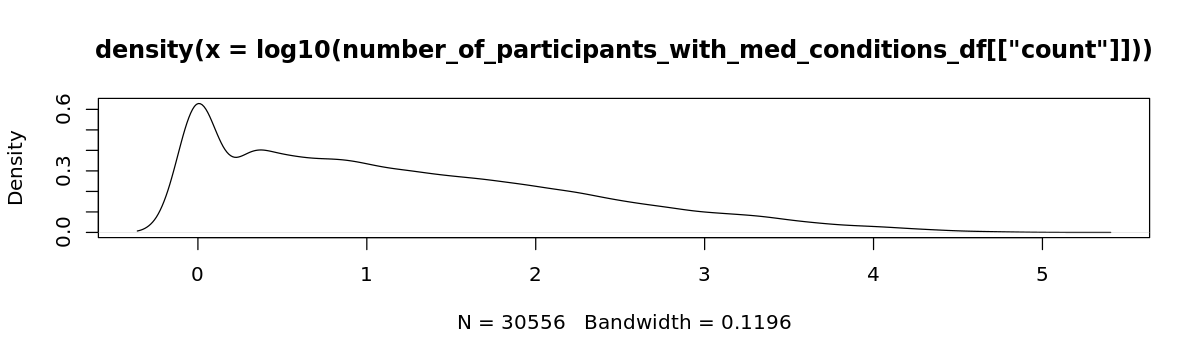

In [13]:
options(repr.plot.width=10, repr.plot.height=3)
plot(density(log10(number_of_participants_with_med_conditions_df[['count']])))

### Reviewer question: The number of female participants who have EHR and number of male participants who have EHR are not included clearly. Those numbers should be reported at the beginning of the manuscript.

In [14]:
# Execute the query and download the results into a DataFrame
participants_by_sex_df <- bq_table_download(bq_project_query(
    BILLING_PROJECT_ID, 
    page_size = 25000,
    query = glue::glue('
SELECT
    p.sex_at_birth_concept_id,
    COUNT(DISTINCT m.person_id) AS unique_subject_count
FROM `{CDR}.condition_occurrence` m 
LEFT JOIN `{CDR}.person` p ON m.person_id = p.person_id
WHERE m.person_id NOT IN (',paste(noncisgender_person_df$person_id,collapse=","),')
GROUP BY p.sex_at_birth_concept_id
')
))
setDT(participants_by_sex_df)
# Display the first few rows of the DataFrame
head(participants_by_sex_df)

sex_at_birth_concept_id,unique_subject_count
<int>,<int>
45878463,152551
45880669,92597


participants with condition data available

In [15]:
participants_by_sex_df[,sum(unique_subject_count)]

[1] 245148

### find out the number of participants with medical conditions

#### We want to limit the conditions to those with 20 or more counts to avoid reporting limit

In [16]:
frequent_cond<-number_of_participants_with_med_conditions_df[count>=20][['standard_concept_id']]

In [17]:
cat(paste(length(frequent_cond),"conditions reported in at least 20 participants."))

12744 conditions reported in at least 20 participants.

#### download table with conditions counted separately by sex_at_birth

In [18]:
participants_with_med_conditions_by_sex_df <- bq_table_download(bq_project_query(
    BILLING_PROJECT_ID, page_size = 25000,
    query = str_glue('
SELECT 
    m.condition_concept_id AS standard_concept_id,
    c.concept_name as concept_name,
    p.sex_at_birth_concept_id,
    COUNT(DISTINCT m.person_id) as count
FROM `{CDR}.condition_occurrence` m 
LEFT JOIN `{CDR}.concept` c 
ON m.condition_concept_id = c.concept_id 
LEFT JOIN `{CDR}.person` p
ON m.person_id = p.person_id
WHERE m.condition_concept_id IN (',paste(frequent_cond,collapse=","),')
AND m.person_id NOT IN (',paste(noncisgender_person_df$person_id,collapse=","),')
GROUP BY m.condition_concept_id, c.concept_name, p.sex_at_birth_concept_id
ORDER BY m.condition_concept_id, count DESC
')))

head(participants_with_med_conditions_by_sex_df)

standard_concept_id,concept_name,sex_at_birth_concept_id,count
<int>,<chr>,<int>,<int>
0,No matching concept,45878463,45
0,No matching concept,45880669,27
22274,Neoplasm of uncertain behavior of larynx,45880669,42
22274,Neoplasm of uncertain behavior of larynx,45878463,27
22281,Sickle cell-hemoglobin SS disease,45878463,57
22281,Sickle cell-hemoglobin SS disease,45880669,35


In [19]:
fwrite(participants_with_med_conditions_by_sex_df,'cisgender_participants_with_med_conditions_by_sex_df')

In [20]:
participants_with_med_conditions_by_sex_df<-fread('cisgender_participants_with_med_conditions_by_sex_df')

#### remove conditions with zero concept_id

In [21]:
setDT(participants_with_med_conditions_by_sex_df)
dim(participants_with_med_conditions_by_sex_df)
participants_with_med_conditions_by_sex_df<-participants_with_med_conditions_by_sex_df[standard_concept_id!=0]
dim(participants_with_med_conditions_by_sex_df)

[1] 24721     4

[1] 24719     4

#### explore distribution of counts by conditions in males

In [22]:
# 45880669 (male) Look for conditions with a sex bias
male_cond_count<-participants_with_med_conditions_by_sex_df[, list(
  male_count = sum(count[sex_at_birth_concept_id == 45880669]),
  total_count = sum(count)
), by = .(standard_concept_id, concept_name)]
male_cond_count[,male_frac:=male_count/total_count]

*Looks like trimodal distribution* - female-specific to the left, sex non-sepcific in the middle, and male-specific to the right.

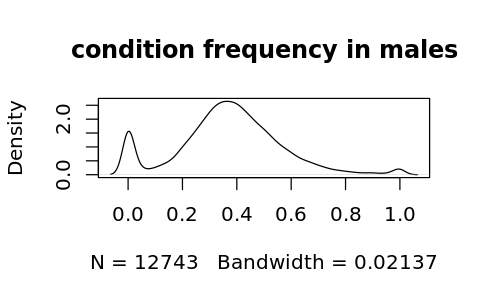

In [23]:
options(repr.plot.width=4, repr.plot.height=2.5)
plot(density(male_cond_count[['male_frac']]),main='condition frequency in males')

#### we set sex-specific conditions as those observed in over 95% or under 5% of males

In [24]:
sex_cond<-male_cond_count[male_frac>.95|male_frac<.05]
cat(paste(nrow(sex_cond),'conditions'))
head(sex_cond[male_count>20])

1314 conditions

standard_concept_id,concept_name,male_count,total_count,male_frac
<int>,<chr>,<int>,<int>,<dbl>
26662,Testicular hypofunction,4157,4201,0.989526303
26935,Disorder of endocrine testis,229,230,0.995652174
30969,Testicular hyperfunction,52,53,0.981132075
72576,Benign tumor of breast,21,2578,0.008145849
73723,Benign neoplasm of epididymis,23,24,0.958333333
73819,Pain of breast,593,13598,0.043609354


#### exclude breast since males also have breast and can have rare breast-related diseases

In [25]:
sex_cond<-sex_cond[grep("breast|mamm",concept_name,ignore.case = T,invert = T)]
cat(paste(nrow(sex_cond),'conditions'))

1183 conditions

Conditions observed in 100% male or 100% female participants are rarer than those observed in mixed sexes

*Figure 1a*

png 
  2

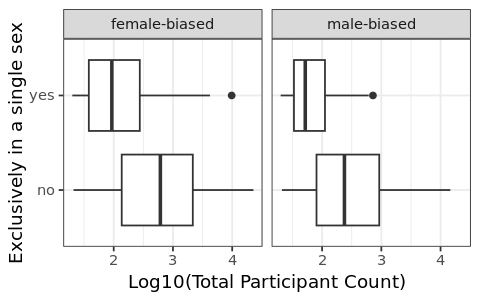

In [26]:
options(repr.plot.width=4, repr.plot.height=2.5)
g<-ggplot(sex_cond,aes(x=log10(total_count),
                    y=ifelse(male_frac%in%c(1,0),'yes','no')))+geom_boxplot()+
ylab("Exclusively in a single sex")+theme_bw()+xlab('Log10(Total Participant Count)')+
facet_grid(~ifelse(male_frac>.5,'male-biased','female-biased'));g
pdf('output/condition_size_by_exclusivity.pdf',w=4,h=2.5)
g
dev.off()

There are more conditions with 100% concordance (probably because they are less frequent and do not allow this problem to be detected)  
The number of conditions by sex is quite different

*Figure 1b*

In [27]:
condition_breakdown<-sex_cond[,.N,by=.(male_frac>.5,male_frac%in%c(1,0))]
colnames(condition_breakdown)[1:2]<-c('male-specific','perfect concordance')
condition_breakdown[order(condition_breakdown[[1]],condition_breakdown[[2]])]

male-specific,perfect concordance,N
<lgl>,<lgl>,<int>
FALSE,FALSE,379
FALSE,TRUE,647
TRUE,FALSE,78
TRUE,TRUE,79


In [28]:
cat(paste("Female-biased conditions are",round(sum(condition_breakdown[which(!`male-specific`)][['N']])/
      sum(condition_breakdown[which(`male-specific`)][['N']]),2),"folds of male-biased conditions"))

Female-biased conditions are 6.54 folds of male-biased conditions

#### explore number of subjects by sex and by sex-biased conditions (absolute vs. mixed)

In [29]:
sex_cond[,female_count:=total_count-male_count]
sex_cond[,female_frac:=1-male_frac]

In [30]:
sex_cond.backup<-sex_cond

In [31]:
cat(paste(sum(with(sex_cond[male_frac==1],male_count)),"males have 100% male-biased conditions"))

9005 males have 100% male-biased conditions

In [32]:
cat(paste(sum(with(sex_cond[male_frac==0],total_count-male_count)),"females have 100% female-biased conditions"))

200328 females have 100% female-biased conditions

In [33]:
cat(paste("ratio of F:M is",round(200328/9005,1),'in conditions with 100% sex concordance'))

ratio of F:M is 22.2 in conditions with 100% sex concordance

In [34]:
sex_cond<-sex_cond[male_frac!=0 & male_frac!=1][order(male_frac)]

In [35]:
cat(paste(sum(with(sex_cond[male_frac>.5],male_count)),"males have male-biased conditions"))

109588 males have male-biased conditions

In [36]:
cat(paste(sum(with(sex_cond[male_frac>.5],total_count-male_count)),"females have male-biased conditions"))

515 females have male-biased conditions

In [37]:
cat(paste(sum(with(sex_cond[male_frac<.5],total_count-male_count)),"females have female-biased conditions"))

741548 females have female-biased conditions

In [38]:
cat(paste(sum(with(sex_cond[male_frac<.5],male_count)),"males have female-biased conditions"))

2025 males have female-biased conditions

#### what is the relationship between total count and % mix up?

In [39]:
female_cond<-sex_cond[male_frac<.5][['standard_concept_id']]
male_cond<-sex_cond[male_frac>.5][['standard_concept_id']]

*Figure 3a*

png 
  2

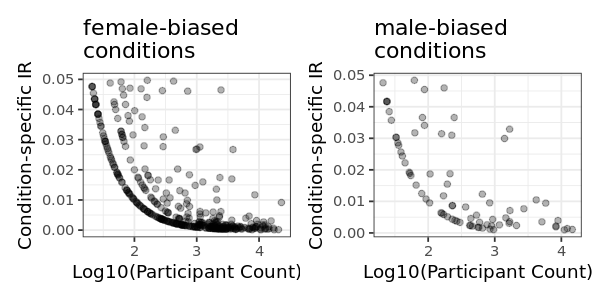

In [40]:
g1<-ggplot(sex_cond[standard_concept_id%in%female_cond],aes(x=log10(total_count),y=male_frac))+
geom_point(alpha=.3)+theme_bw()+ggtitle("female-biased\nconditions")+
ylab('Condition-specific IR')+xlab('Log10(Participant Count)')
g2<-ggplot(sex_cond[standard_concept_id%in%male_cond],aes(x=log10(total_count),y=(1-male_frac)))+
geom_point(alpha=.3)+theme_bw()+ggtitle("male-biased\nconditions")+
ylab('Condition-specific IR')+xlab('Log10(Participant Count)')
options(repr.plot.width=5, repr.plot.height=2.5);g1|g2
pdf('output/CIR_all_conditions.pdf',w=5,h=2.5);g1|g2;dev.off()

The fraction is more reliable when the total count is big, so we want to limit the investigation to those with more than 1000 cases and have 20 or more mixed up cases.

In [41]:
length(female_cond)
length(male_cond)

[1] 379

[1] 78

In [42]:
sex_cond<-sex_cond[total_count>1000]
female_cond<-sex_cond[male_frac<.5][['standard_concept_id']]
male_cond<-sex_cond[male_frac>.5][['standard_concept_id']]
length(female_cond)
length(male_cond)

[1] 162

[1] 18

*Figure 3b*

png 
  2

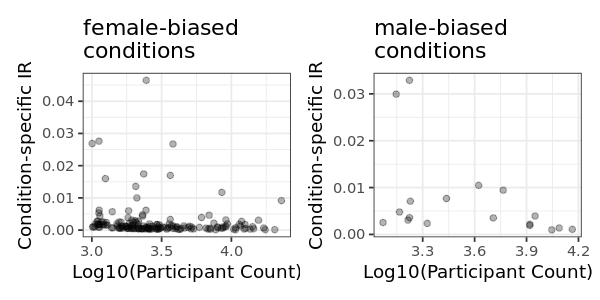

In [43]:
g1<-ggplot(sex_cond[standard_concept_id%in%female_cond],aes(x=log10(total_count),y=male_frac))+
geom_point(alpha=.3)+theme_bw()+ggtitle("female-biased\nconditions")+
ylab('Condition-specific IR')+xlab('Log10(Participant Count)')
g2<-ggplot(sex_cond[standard_concept_id%in%male_cond],aes(x=log10(total_count),y=(1-male_frac)))+
geom_point(alpha=.3)+theme_bw()+ggtitle("male-biased\nconditions")+
ylab('Condition-specific IR')+xlab('Log10(Participant Count)')
options(repr.plot.width=5, repr.plot.height=2.5);g1|g2
pdf('output/CIR_large_conditions.pdf',w=5,h=2.5);g1|g2;dev.off()

#### Filter by non-exclusivity

Ask ChatGPT to identify terms that are not sex-specific

Prompt:
Here is a list of conditions. Please go through all of these terms and provide justification one at a time, explain whether they are sex-specific based on your knowledge. At the end, construct the list of non-sex-specific conditions in the form of an R character vector.



In [44]:
length(sex_cond[[2]])

[1] 180

In [45]:
sex_cond[[2]]

[1] "Acute vaginitis"                                                                                   
  [2] "Menopause present"                                                                                 
  [3] "Postmenopausal bleeding"                                                                           
  [4] "Noninflammatory disorder of the vagina"                                                            
  [5] "Acquired absence of cervix and uterus"                                                             
  [6] "Vulval and/or perineal noninflammatory disorders"                                                  
  [7] "Excessive and frequent menstruation"                                                               
  [8] "Finding of menstrual bleeding"                                                                     
  [9] "Cervicitis and endocervicitis"                                                                     
 [10] "Cyst of ovary"                                                                                     
 [11] "Leukorrhea"                                                                                        
 [12] "Uterine leiomyoma"                                                                                 
 [13] "Labor and delivery complicated by fetal heart rate anomaly"                                        
 [14] "Subserous leiomyoma of uterus"                                                                     
 [15] "Gestation period, 32 weeks"                                                                        
 [16] "Gestation period, 40 weeks"                                                                        
 [17] "Intramural leiomyoma of uterus"                                                                    
 [18] "Intermenstrual bleeding - irregular"                                                               
 [19] "Cord entanglement without compression"                                                             
 [20] "Gestation period, 18 weeks"                                                                        
 [21] "Gestation period, 8 weeks"                                                                         
 [22] "Reduced fetal movement"                                                                            
 [23] "Endometriosis of uterus"                                                                           
 [24] "Herniation of rectum into vagina"                                                                  
 [25] "Irregular periods"                                                                                 
 [26] "Cervical intraepithelial neoplasia grade 1"                                                        
 [27] "Gestation period, 30 weeks"                                                                        
 [28] "Submucous leiomyoma of uterus"                                                                     
 [29] "Poor fetal growth affecting management"                                                            
 [30] "Polyp of corpus uteri"                                                                             
 [31] "Deliveries by cesarean"                                                                            
 [32] "Disorder of uterus"                                                                                
 [33] "Inflammation of cervix"                                                                            
 [34] "Excessive fetal growth affecting management of mother"                                             
 [35] "Vomiting of pregnancy"                                                                             
 [36] "Maternal obesity complicating pregnancy, childbirth and the puerperium, antepartum"                
 [37] "Gestation period, 29 weeks"                                                                        
 [38] "Antepartum hemorrhage"              

In [46]:
non_sex_specific_conditions <- c('Dyspareunia', 'Group B Streptococcus carrier', 'Estrogen receptor positive tumor',
                                 'Candida infection of genital region', 'Carrier of cystic fibrosis gene mutation',
                                 'Discharge from nipple', 'Hirsutism', 'Lichen sclerosus et atrophicus', 
                                 'Genitourinary tract hemorrhage',
                                 # newly added by Dr. DeBerardinis:
                                 'Raised prostate specific antigen','Leukorrhea',
                                 # removed by Dr. DeBerardinis:
                                # 'Drug dependence in mother complicating pregnancy, childbirth AND/OR puerperium',
                                 'Asymptomatic', 'Psychosexual dysfunction associated with inhibited sexual excitement')

In [47]:
table(non_sex_specific_conditions%in%sex_cond$concept_name)


TRUE 
  13 

In [48]:
sex_cond<-sex_cond[!concept_name%in%non_sex_specific_conditions]

In [49]:
nrow(sex_cond)

[1] 167

In [50]:
cat(paste(nrow(sex_cond[male_frac<.5]),"female-specific conditions."))
summary(sex_cond[male_frac<.5][['male_frac']])

151 female-specific conditions.

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
9.344e-05 5.357e-04 9.862e-04 1.968e-03 1.873e-03 2.687e-02 

In [51]:
cat(paste(nrow(sex_cond[male_frac>.5]),"male-specific conditions."))
summary(1-sex_cond[male_frac>.5][['male_frac']])

16 male-specific conditions.

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0009901 0.0022530 0.0035533 0.0058619 0.0072380 0.0299359 

#### Prepare Table 1 and supplementary table

In [52]:
sex_cond[,female_count:=total_count-male_count]
sex_cond[,female_frac:=1-male_frac]

In [53]:
sex_cond<-sex_cond[,c('standard_concept_id','concept_name','male_count','female_count',
                      'total_count','male_frac','female_frac'),with=F]

In [54]:
sex_cond_report_full<-data.table(sex_specificity=ifelse(sex_cond$male_frac<.5,'female','male'),sex_cond)

In [55]:
sex_cond_report_full[sex_specificity=='female',incongruent_count:=male_count]
sex_cond_report_full[sex_specificity=='male',incongruent_count:=female_count]
sex_cond_report_full[sex_specificity=='female',incongruent_freq:=male_frac]
sex_cond_report_full[sex_specificity=='male',incongruent_freq:=female_frac]

In [56]:
incongruent_CI<-rep('',nrow(sex_cond_report_full))
for(i in 1:nrow(sex_cond_report_full)) 
    incongruent_CI[i]<-with(sex_cond_report_full,CI(p = incongruent_freq[i],n=incongruent_count[i]))

sex_cond_report_full[,incongruent_CI:=incongruent_CI]

In [57]:
sex_cond_report_full[,female_frac:=round(female_frac,4)][,male_frac:=round(male_frac,4)]

*Table 1*

In [58]:
rbind(sex_cond_report_full[sex_specificity=='female'][order(-male_frac)][1:3],
sex_cond_report_full[sex_specificity=='male'][order(-female_frac)][1:3])

sex_specificity,standard_concept_id,concept_name,male_count,female_count,total_count,male_frac,female_frac,incongruent_count,incongruent_freq,incongruent_CI
<chr>,<int>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<dbl>,<chr>
female,440787,"Drug dependence in mother complicating pregnancy, childbirth AND/OR puerperium",27,978,1005,0.0269,0.9731,27,0.02686567,"[-0.034, 0.088]"
female,201909,Female infertility,102,3715,3817,0.0267,0.9733,102,0.02672256,"[-0.0046, 0.058]"
female,4279913,Primary ovarian failure,62,3591,3653,0.0170,0.9830,62,0.01697235,"[-0.015, 0.049]"
male,197605,Inflammatory disorder of male genital organ,1361,42,1403,0.9701,0.0299,42,0.02993585,"[-0.022, 0.081]"
male,26662,Testicular hypofunction,4157,44,4201,0.9895,0.0105,44,0.01047370,"[-0.02, 0.041]"
male,200962,Primary malignant neoplasm of prostate,5770,55,5825,0.9906,0.0094,55,0.00944206,"[-0.016, 0.035]"


In [59]:
sex_cond_report_full[,male_count2:=as.character(male_count)][,female_count2:=as.character(female_count)]
sex_cond_report_full[male_count<=20,male_count2:='<=20']
sex_cond_report_full[male_count<=20,female_count2:=paste0('>=',total_count-20)]
sex_cond_report_full[female_count<=20,female_count2:='<=20']
sex_cond_report_full[female_count<=20,male_count2:=paste0('>=',total_count-20)]

In [60]:
sex_cond_report_full[,male_count:=male_count2][,male_count2:=NULL][,female_count:=female_count2][,female_count2:=NULL]
sex_cond_report_full[male_count=='<=20'|female_count=='<=20',male_frac:=NA]
sex_cond_report_full[male_count=='<=20'|female_count=='<=20',female_frac:=NA]

*Table S1*

In [61]:
fwrite(sex_cond_report_full[order(-total_count)],'Table_S1_167_conditions.csv')

#### limit our subsequent investigation to sex-specific conditions observed in mixed sexs

In [62]:
female_cond<-sex_cond[male_frac<.5][['standard_concept_id']]
male_cond<-sex_cond[male_frac>.5][['standard_concept_id']]

In [63]:
length(female_cond)
length(male_cond)

[1] 151

[1] 16

### Evaluate impact from gender fluidity

#### males_w_m, males_w_f, females_w_m, females_w_f

In [64]:
males_w_m_cond <- bq_table_download(bq_project_query(
    BILLING_PROJECT_ID, page_size = 25000,
    query = str_glue('
SELECT 
    m.person_id,
    m.condition_concept_id,
    c.concept_name
FROM `{CDR}.condition_occurrence` m 
JOIN `{CDR}.concept` c ON m.condition_concept_id = c.concept_id 
JOIN `{CDR}.person` p ON m.person_id = p.person_id
WHERE p.sex_at_birth_concept_id = 45880669 
AND m.condition_concept_id IN (',paste(male_cond,collapse=","),')
')))

In [65]:
males_w_f_cond <- bq_table_download(bq_project_query(
    BILLING_PROJECT_ID, page_size = 25000,
    query = str_glue('
SELECT 
    m.person_id,
    m.condition_concept_id,
    c.concept_name
FROM `{CDR}.condition_occurrence` m 
JOIN `{CDR}.concept` c ON m.condition_concept_id = c.concept_id 
JOIN `{CDR}.person` p ON m.person_id = p.person_id
WHERE p.sex_at_birth_concept_id = 45880669 
AND m.condition_concept_id IN (',paste(female_cond,collapse=","),')
')))

In [66]:
females_w_f_cond <- bq_table_download(bq_project_query(
    BILLING_PROJECT_ID, page_size = 25000,
    query = str_glue('
SELECT 
    m.person_id,
    m.condition_concept_id,
    c.concept_name
FROM `{CDR}.condition_occurrence` m 
JOIN `{CDR}.concept` c ON m.condition_concept_id = c.concept_id 
JOIN `{CDR}.person` p ON m.person_id = p.person_id
WHERE p.sex_at_birth_concept_id = 45878463 
AND m.condition_concept_id IN (',paste(female_cond,collapse=","),')
')))

In [67]:
females_w_m_cond <- bq_table_download(bq_project_query(
    BILLING_PROJECT_ID, page_size = 25000,
    query = str_glue('
SELECT 
    m.person_id,
    m.condition_concept_id,
    c.concept_name
FROM `{CDR}.condition_occurrence` m 
JOIN `{CDR}.concept` c ON m.condition_concept_id = c.concept_id 
JOIN `{CDR}.person` p ON m.person_id = p.person_id
WHERE p.sex_at_birth_concept_id = 45878463 
AND m.condition_concept_id IN (',paste(male_cond,collapse=","),')
')))

In [68]:
males_w_m<-as.data.table(males_w_m_cond)[,.N,by=.(person_id,condition_concept_id,concept_name)]
females_w_f<-as.data.table(females_w_f_cond)[,.N,by=.(person_id,condition_concept_id,concept_name)]
males_w_f<-as.data.table(males_w_f_cond)[,.N,by=.(person_id,condition_concept_id,concept_name)]
females_w_m<-as.data.table(females_w_m_cond)[,.N,by=.(person_id,condition_concept_id,concept_name)]

In [69]:
fwrite(males_w_m,'males_with_male_conditions.csv')
fwrite(males_w_f,'males_with_female_conditions.csv')
fwrite(females_w_m,'females_with_male_conditions.csv')
fwrite(females_w_f,'females_with_female_conditions.csv')

In [70]:
males_w_m<-fread('males_with_male_conditions.csv')
males_w_f<-fread('males_with_female_conditions.csv')
females_w_m<-fread('females_with_male_conditions.csv')
females_w_f<-fread('females_with_female_conditions.csv')

In [71]:
fwm_subject<-unique(females_w_m[['person_id']])
mwf_subject<-unique(males_w_f[['person_id']])

In [72]:
length(unique(males_w_m[['person_id']]))

[1] 36422

In [73]:
length(unique(females_w_f[['person_id']]))

[1] 96285

In [74]:
length(fwm_subject)

[1] 338

In [75]:
length(mwf_subject)

[1] 950

In [76]:
cat(paste(36422+96285+338+950,"participants with 167 selected conditions (Without sex-conforming gender)"))

133995 participants with 167 selected conditions (Without sex-conforming gender)

In [77]:
length(fwm_subject)+length(mwf_subject)

[1] 1288

#### confirm incongruent participant sex by microarray autogenderCalls

In [78]:
person_df <- bq_table_download(bq_project_query(
    BILLING_PROJECT_ID, page_size = 25000,
    query = str_glue('
SELECT 
    person_id,sex_at_birth_source_value,gender_source_value
FROM {CDR}.person
WHERE person_id IN (',paste(unique(c(fwm_subject,mwf_subject)),collapse=","),')
')))
setDT(person_df)

In [79]:
affected.ids<-unique(c(females_w_m_cond[['person_id']],males_w_f_cond[['person_id']]))
length(affected.ids)
fwrite(data.table(s=affected.ids),'affected_ids.txt')

[1] 1288

In [80]:
library(data.table)

run bash script to retreive genomically inferred sex and output as resolved_sex.txt

In [81]:
resolved<-fread('resolved_sex.txt')
resolved<-resolved[V1%in%affected.ids]
resolved<-resolved[!is.na(V2)]

In [82]:
resolved[,sex_at_birth:=person_df[match(resolved[['V1']],person_id)][['sex_at_birth_source_value']]]

In [83]:
cat(paste(nrow(resolved),"participants have genomics-inferred sex available."))

1027 participants have genomics-inferred sex available.

Note that 1288 is the total incongruent cases and 1027 are the genomically confirmed cases. These numbers include non-cisgender participants

In [84]:
# Perfect match
resolved[,.N,by=.(V2,sex_at_birth)]

V2,sex_at_birth,N
<chr>,<chr>,<int>
F,SexAtBirth_Female,252
M,SexAtBirth_Male,775


Here are the numbers excluding non-cisgender participants

In [85]:
table(affected.ids%in%noncisgender_person_df$person_id)


FALSE  TRUE 
 1134   154 

In [88]:
cat(paste(nrow(resolved[!V1%in%noncisgender_person_df$person_id]),
      "cisgender participants have sex at birth confirmed by genomics-inferred sex"))

978 cisgender participants have sex at birth confirmed by genomics-inferred sex

#### compare gender distribution in all participants vs. incongruent cases

##### prepare figure in all subjects

In [89]:
all_cond_count_by_sex <- bq_table_download(bq_project_query(
    BILLING_PROJECT_ID, page_size = 25000,
    query = str_glue('
SELECT 
    p.sex_at_birth_source_value AS sex,
    COUNT(DISTINCT m.person_id) as unique_person_count
FROM `{CDR}.condition_occurrence` m
JOIN `{CDR}.person` p
ON m.person_id = p.person_id
GROUP BY p.sex_at_birth_source_value
')))
all_cond_count_by_sex

sex,unique_person_count
<chr>,<int>
SexAtBirth_Female,154914
SexAtBirth_Male,94413
No matching concept,2403
PMI_Skip,2455
PMI_PreferNotToAnswer,172
SexAtBirth_SexAtBirthNoneOfThese,81
SexAtBirth_Intersex,49


In [90]:
setDT(all_cond_count_by_sex)

In [91]:
all_person_freq<-all_person_df[sex_at_birth_source_value%in%c('SexAtBirth_Male','SexAtBirth_Female'),.N,
                               by=.(sex_at_birth_source_value,gender_source_value)]
all_person_freq<-all_person_freq[!grepl('PMI',gender_source_value)]
all_person_freq[!grepl("Man|Woman",gender_source_value),other:=T]

In [92]:
all_other_df<-data.table(gender_source_value=paste(gsub('GenderIdentity_','',unique(all_person_freq[!grepl("Man|Woman",gender_source_value)][['gender_source_value']])),
      collapse = '/'),all_person_freq[,list(N=sum(N)),by=.(other,sex_at_birth_source_value)][!is.na(other)])

In [93]:
all_person_freq2<-rbind(all_person_freq[grepl("Man|Woman",gender_source_value),c('sex_at_birth_source_value','gender_source_value','N')],
all_other_df[,c('sex_at_birth_source_value','gender_source_value','N')])

In [94]:
all_person_freq2[,frac:=N/sum(N),by=sex_at_birth_source_value]

In [95]:
g1<-ggplot(all_person_freq2,aes(y=gender_source_value,x=frac))+geom_bar(stat='identity')+
facet_wrap(~sex_at_birth_source_value,ncol=1)+theme_bw()+theme(axis.title.y = element_blank())+
ggtitle("all participants")

##### top frequent conditions (in person/across person) in non-cisgender subjets

In [96]:
noncis_mwf<-person_df[sex_at_birth_source_value=='SexAtBirth_Male' & !gender_source_value%in%c('GenderIdentity_Man','PMI_Skip','PMI_PreferNotToAnswer')]
noncis_fwm<-person_df[sex_at_birth_source_value=='SexAtBirth_Female' & !gender_source_value%in%c('GenderIdentity_Woman','PMI_Skip','PMI_PreferNotToAnswer')]

##### prepare figure in incongruent cases

In [97]:
sex_match.df<-rbind(person_df[person_id%in%females_w_m_cond[['person_id']],.N,
                                     by=.(sex_at_birth_source_value,gender_source_value)],
person_df[person_id%in%males_w_f_cond[['person_id']],.N,
                                     by=.(sex_at_birth_source_value,gender_source_value)])

In [98]:
cisgender.ind<-person_df[,.I[(sex_at_birth_source_value=='SexAtBirth_Male' & gender_source_value=='GenderIdentity_Man')|
         (sex_at_birth_source_value=='SexAtBirth_Female' & gender_source_value=='GenderIdentity_Woman')]]

In [99]:
noncisgender.person_df<-person_df[-cisgender.ind] # 158

In [100]:
sex_match.df<-sex_match.df[!grepl('PMI',gender_source_value)]
sex_match.df[!grepl("Man|Woman",gender_source_value),other:=T]

In [101]:
sex_match_other.df<-data.table(gender_source_value=all_other_df[['gender_source_value']][1],
                               sex_match.df[,list(N=sum(N)),by=.(other,sex_at_birth_source_value)][!is.na(other)])

In [102]:
sex_match.df2<-rbind(sex_match.df[grepl("Man|Woman",gender_source_value),c('sex_at_birth_source_value','gender_source_value','N')],
sex_match_other.df[,c('sex_at_birth_source_value','gender_source_value','N')])
sex_match.df2[,frac:=N/sum(N),by=sex_at_birth_source_value]

In [103]:
g2<-ggplot(sex_match.df2,aes(y=gender_source_value,x=frac))+geom_bar(stat='identity')+
facet_wrap(~sex_at_birth_source_value,ncol=1)+theme_bw()+theme(axis.title.y = element_blank())+
ggtitle("participants with\nincongruent sex-specific conditions")

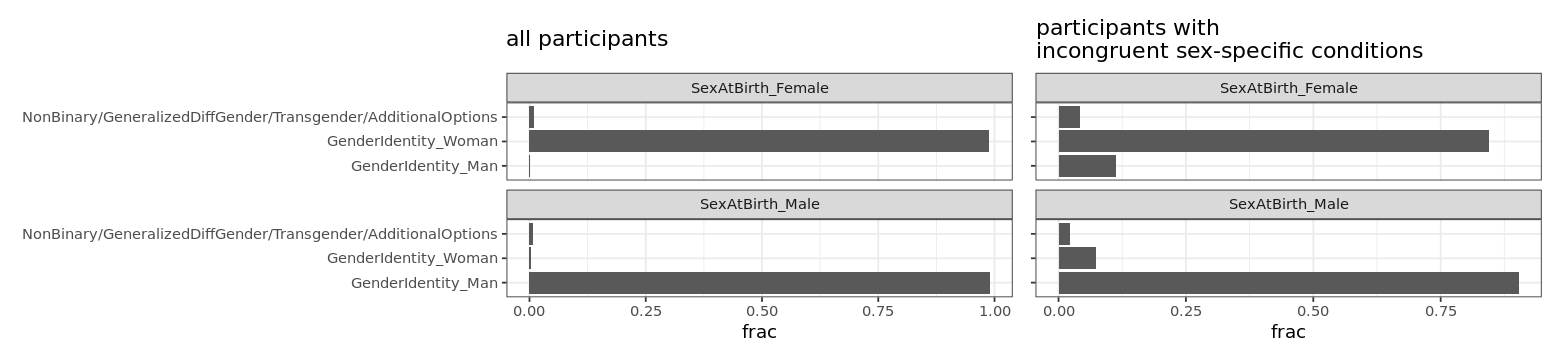

In [104]:
options(repr.plot.width=13, repr.plot.height=3)
g1|(g2+theme(axis.text.y = element_blank()))

In [105]:
all_person_freq2[gender_source_value=='NonBinary/GeneralizedDiffGender/Transgender/AdditionalOptions',
             gender_source_value:="NonBinary/GeneralizedDiffGender\n/Transgender/AdditionalOptions"]

In [106]:
g1<-ggplot(all_person_freq2,aes(y=gender_source_value,x=frac))+geom_bar(stat='identity')+
facet_wrap(~sex_at_birth_source_value,ncol=1)+theme_bw()+theme(axis.title.y = element_blank())+
ggtitle("all participants")

*Figure 4*

png 
  2

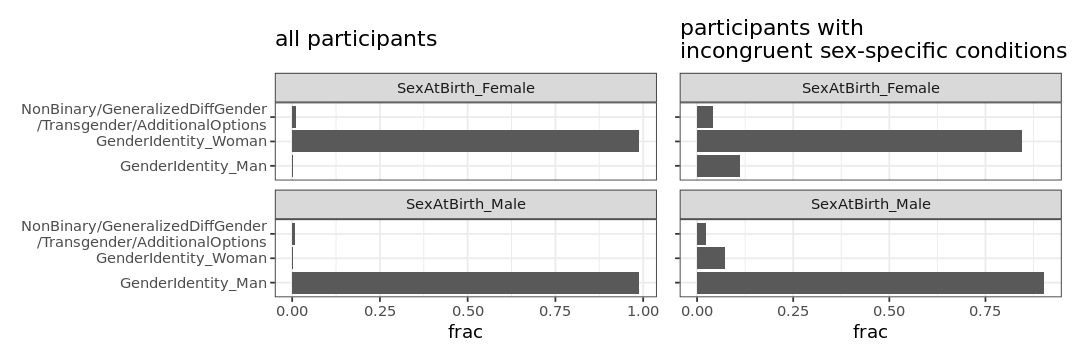

In [107]:
options(repr.plot.width=9, repr.plot.height=3);g1|(g2+theme(axis.text.y = element_blank()))
pdf('output/gender_distribution_all_vs_incongruent.pdf',w=8,h=3)
g1|(g2+theme(axis.text.y = element_blank()))
dev.off()

How does sex at birth match with gender from the survey data

In [108]:
all_person_freq2

sex_at_birth_source_value,gender_source_value,N,frac
<chr>,<chr>,<int>,<dbl>
SexAtBirth_Male,GenderIdentity_Man,152093,0.989589636
SexAtBirth_Male,GenderIdentity_Woman,424,0.002758746
SexAtBirth_Female,GenderIdentity_Woman,245131,0.988419495
SexAtBirth_Female,GenderIdentity_Man,514,0.002072556
SexAtBirth_Male,NonBinary/GeneralizedDiffGender /Transgender/AdditionalOptions,1176,0.007651617
SexAtBirth_Female,NonBinary/GeneralizedDiffGender /Transgender/AdditionalOptions,2358,0.009507950


### OIR calculation

#### include all biological females and males

In [109]:
mf.n<-length(unique(males_w_f[['person_id']]));mf.n
ff.n<-length(unique(females_w_f[['person_id']]));ff.n
fm.n<-length(unique(females_w_m[['person_id']]));fm.n
mm.n<-length(unique(males_w_m[['person_id']]));mm.n

[1] 950

[1] 96285

[1] 338

[1] 36422

In [110]:
mf.n/(mf.n+ff.n)
fm.n/(fm.n+mm.n)
(fm.n+mf.n)/(mf.n+ff.n+fm.n+mm.n)

[1] 0.009770144

[1] 0.009194777

[1] 0.009612299

In [111]:
CI(p = mf.n/(mf.n+ff.n),n=mf.n+ff.n)
CI(p = fm.n/(fm.n+mm.n),n=fm.n+mm.n)
CI(p = (fm.n+mf.n)/(mf.n+ff.n+fm.n+mm.n),n=mf.n+ff.n+fm.n+mm.n)

[1] "[0.0092, 0.01]"

[1] "[0.0082, 0.01]"

[1] "[0.0091, 0.01]"

In [112]:
mf.n+ff.n+fm.n+mm.n

[1] 133995

In [113]:
length(unique(females_w_f[['person_id']]))/
all_cond_count_by_sex[sex=='SexAtBirth_Female'][['unique_person_count']]
length(unique(males_w_m[['person_id']]))/
all_cond_count_by_sex[sex=='SexAtBirth_Male'][['unique_person_count']]

[1] 0.6215384

[1] 0.3857731

#### OIR excluding non-cisgender participants

In [150]:
all_person_df[,.N,by=gender_source_value]

gender_source_value,N
<chr>,<int>
PMI_Skip,7356
No matching concept,97
GenderIdentity_Man,154241
GenderIdentity_Woman,247453
PMI_PreferNotToAnswer,602
GenderIdentity_GeneralizedDiffGender,1526
GenderIdentity_AdditionalOptions,407
GenderIdentity_Transgender,562
GenderIdentity_NonBinary,1213


##### within Male and Female gender

In [133]:
binary_gender_person_df<-all_person_df[gender_source_value%in%c('GenderIdentity_Man','GenderIdentity_Woman')]

In [134]:
mf.n<-length(intersect(binary_gender_person_df$person_id,unique(males_w_f[['person_id']])));mf.n
ff.n<-length(intersect(binary_gender_person_df$person_id,unique(females_w_f[['person_id']])));ff.n
fm.n<-length(intersect(binary_gender_person_df$person_id,unique(females_w_m[['person_id']])));fm.n
mm.n<-length(intersect(binary_gender_person_df$person_id,unique(males_w_m[['person_id']])));mm.n

[1] 918

[1] 95148

[1] 323

[1] 35921

In [135]:
mf.n+ff.n+fm.n+mm.n

[1] 132310

In [136]:
mf.n/(mf.n+ff.n)
fm.n/(fm.n+mm.n)
(fm.n+mf.n)/(mf.n+ff.n+fm.n+mm.n)

[1] 0.00955593

[1] 0.00891182

[1] 0.009379488

In [137]:
CI(p = (fm.n+mf.n)/(mf.n+ff.n+fm.n+mm.n),n=mf.n+ff.n+fm.n+mm.n)

[1] "[0.0089, 0.0099]"

##### Strictly non-cisgender (Table 1, bottom half)

In [139]:
all_cisgender_person_df<-all_person_df[which(!noncisgender)]

In [140]:
mf.n<-length(intersect(all_cisgender_person_df$person_id,unique(males_w_f[['person_id']])));mf.n
ff.n<-length(intersect(all_cisgender_person_df$person_id,unique(females_w_f[['person_id']])));ff.n
fm.n<-length(intersect(all_cisgender_person_df$person_id,unique(females_w_m[['person_id']])));fm.n
mm.n<-length(intersect(all_cisgender_person_df$person_id,unique(males_w_m[['person_id']])));mm.n

[1] 849

[1] 95015

[1] 285

[1] 35875

In [141]:
mf.n+mm.n
ff.n+fm.n

[1] 36724

[1] 95300

In [142]:
mf.n+ff.n+fm.n+mm.n

[1] 132024

In [143]:
mf.n+fm.n
ff.n+mm.n

[1] 1134

[1] 130890

In [144]:
mf.n/(mf.n+ff.n)
fm.n/(fm.n+mm.n)
(fm.n+mf.n)/(mf.n+ff.n+fm.n+mm.n)

[1] 0.008856296

[1] 0.007881637

[1] 0.008589347

In [145]:
CI(p = mf.n/(mf.n+ff.n),n=mf.n+ff.n)
CI(p = fm.n/(fm.n+mm.n),n=fm.n+mm.n)
CI(p = (fm.n+mf.n)/(mf.n+ff.n+fm.n+mm.n),n=mf.n+ff.n+fm.n+mm.n)

[1] "[0.0083, 0.0094]"

[1] "[0.007, 0.0088]"

[1] "[0.0081, 0.0091]"

In [146]:
mf.id<-intersect(all_noncisgender_person_df$person_id,unique(males_w_f[['person_id']]))
fm.id<-intersect(all_noncisgender_person_df$person_id,unique(females_w_m[['person_id']]))
affected.ids<-unique(c(mf.id,fm.id))
length(affected.ids)

[1] 1134

In [147]:
resolved<-fread('resolved_sex.txt')
resolved<-resolved[V1%in%affected.ids]
dim(resolved)

[1] 1134    2

In [148]:
resolved<-resolved[!is.na(V2)]
dim(resolved)

[1] 978   2

### concurrent sex-specific conditions 

#### opposite sex

In [129]:
# females with male-specific condition subjects
fwm_subject<-unique(females_w_m[['person_id']])
# females with both male-specific and female-specific condition subjects
fwmf_subject<-unique(intersect(females_w_m[['person_id']],females_w_f[['person_id']]))
# males with female-specific condition subjects
mwf_subject<-unique(males_w_f[['person_id']])
# males with both male-specific and female-specific condition subjects
mwfm_subject<-unique(intersect(males_w_f[['person_id']],males_w_m[['person_id']]))
length(fwm_subject)
length(fwmf_subject)
length(mwf_subject)
length(mwfm_subject)
# fraction of subjects with conditions of opposite sex over subjects with incongruent conditions, by sex
length(fwmf_subject)/length(fwm_subject)
length(mwfm_subject)/length(mwf_subject)

[1] 338

[1] 259

[1] 950

[1] 603

[1] 0.7662722

[1] 0.6347368

In [150]:
# compute this within the strictlly cisgender participants (numbers used in text)
fwm.n<-length(intersect(fwm_subject,all_cisgender_person_df$person_id))
fwmf.n<-length(intersect(fwmf_subject,all_cisgender_person_df$person_id))
mwf.n<-length(intersect(mwf_subject,all_cisgender_person_df$person_id))
mwfm.n<-length(intersect(mwfm_subject,all_cisgender_person_df$person_id))
fwm.n
fwmf.n
mwf.n
mwfm.n
fwmf.n/fwm.n
mwfm.n/mwf.n

[1] 285

[1] 248

[1] 849

[1] 583

[1] 0.8701754

[1] 0.6866902

#### multiple unique conditions

In [151]:
N.df<-rbind(data.table(type="females with\nmale conditions",N=females_w_m[['N']]),
     data.table(type="females with\nfemale conditions",N=females_w_f[['N']]),
     data.table(type="males with\nfemale conditions",N=males_w_m[['N']]),
     data.table(type="males with\nmale conditions",N=males_w_f[['N']]))

In [154]:
cat(paste(round(nrow(females_w_m[!person_id%in%noncisgender_person_df$person_id,.N,by=person_id][N>1])/
    nrow(females_w_m[!person_id%in%noncisgender_person_df$person_id,.N,by=person_id]),3),
      " of females with male-specific conditions have more than one of such conditions\n"))
cat(paste(round(nrow(females_w_f[!person_id%in%noncisgender_person_df$person_id,.N,by=person_id][N>1])/
    nrow(females_w_f[!person_id%in%noncisgender_person_df$person_id,.N,by=person_id]),3),
      " of females with female-specific conditions have more than one of such conditions"))

0.056  of females with male-specific conditions have more than one of such conditions
0.771  of females with female-specific conditions have more than one of such conditions

In [155]:
cat(paste(round(nrow(males_w_f[!person_id%in%noncisgender_person_df$person_id,.N,by=person_id][N>1])/
    nrow(males_w_f[!person_id%in%noncisgender_person_df$person_id,.N,by=person_id]),3),
      " of males with female-specific conditions have more than one of such conditions\n"))
cat(paste(round(nrow(males_w_m[!person_id%in%noncisgender_person_df$person_id,.N,by=person_id][N>1])/
    nrow(males_w_m[!person_id%in%noncisgender_person_df$person_id,.N,by=person_id]),3),
      " of males with male-specific conditions have more than one of such conditions"))

0.2  of males with female-specific conditions have more than one of such conditions
0.604  of males with male-specific conditions have more than one of such conditions

### geographical spread

In [156]:
source('../Cohort_builder/data_loader2.R')

In [157]:
person_df<-read_bq_export_from_workspace_bucket(2);setDT(person_df)

[1] "person data chosen."


Loading gs://fc-secure-4f1d4ea4-6226-44c5-8138-471e05dd74f3/bq_exports/ling.cai@researchallofus.org/20230818/person_66357698/person_66357698_000000000000.csv.

Warning message:
“The following named parsers don't match the column names: gender, race, ethnicity, sex_at_birth”


In [158]:
soc_df<-read_bq_export_from_workspace_bucket(5);setDT(soc_df)

[1] "socioeconomics data chosen."


Loading gs://fc-secure-4f1d4ea4-6226-44c5-8138-471e05dd74f3/bq_exports/ling.cai@researchallofus.org/20230717/zip_code_socioeconomic/zip_code_socioeconomic_000000000000.csv.

Warning message:
“The following named parsers don't match the column names: zip3_as_string”


In [159]:
p.df<-rbind(data.table(sex_at_birth='female',id=setdiff(fwm_subject,noncisgender_person_df$person_id)),
    data.table(sex_at_birth='male',id=setdiff(mwf_subject,noncisgender_person_df$person_id)))

In [160]:
zip_mistakes<-soc_df[person_id%in%p.df$id][,.N,by=zip_code][order(-N)]

In [161]:
zip_mistakes[,total:=soc_df[,.N,by=zip_code][match(zip_mistakes$zip_code,zip_code)][['N']]]

In [162]:
zip_mistakes[,frac:=N/sum(N)][,frac.pop:=total/sum(total)]

In [163]:
cat(paste(nrow(zip_mistakes),'zip codes with incongruent cases found.'))

153 zip codes with incongruent cases found.

In [189]:
head(zip_mistakes)

zip_code,N,total,frac,frac.pop
<chr>,<int>,<int>,<dbl>,<dbl>
021**,153,15113,0.13503972,0.04563448
024**,58,3776,0.05119153,0.01140183
606**,45,25467,0.03971756,0.07689892
100**,43,13391,0.03795234,0.04043482
482**,38,3329,0.03353928,0.01005209
352**,35,9791,0.03089144,0.02956443


*Figure 5a*

png 
  2

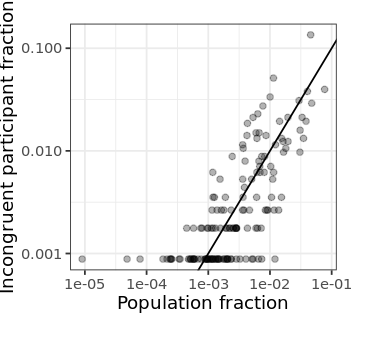

In [164]:
options(repr.plot.width=3.2, repr.plot.height=3)
g<-ggplot(zip_mistakes,aes(x=frac.pop,y=frac))+geom_point(alpha=.3)+geom_abline(intercept = 0,slope = 1)+
scale_x_log10()+scale_y_log10()+theme_bw()+xlab('Population fraction')+ylab('Incongruent participant fraction')+
theme(plot.margin = unit(c(.5,1,1,0), "cm"))
g
pdf('output/zipcode_scatterplot.pdf',w=3.2,h=3)
g
dev.off()

In [165]:
zip.N<-soc_df[,.N,by=zip_code]

In [166]:
zip.N[,issue:=ifelse(zip_code%in%zip_mistakes$zip_code,'yes','no')]

In [167]:
zip.N[,.N,by=issue]

issue,N
<chr>,<int>
no,716
yes,153


*Figure 5b*

png 
  2

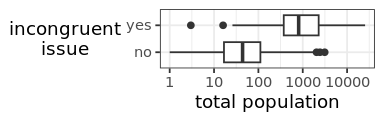

In [168]:
options(repr.plot.width=3.2, repr.plot.height=1)
g<-ggplot(zip.N,aes(x=N,y=issue))+geom_boxplot()+scale_x_log10()+theme_bw()+xlab('total population')+
ylab("incongruent\nissue")+theme(axis.title.y=element_text(angle=0,vjust=0.5))
g
pdf('output/zipcode_binary.pdf',w=3.2,h=1)
g
dev.off()


### Temporal spread

In [170]:
female_assembly <- bq_table_download(bq_project_query(
    BILLING_PROJECT_ID, page_size = 25000,
    query = str_glue('
SELECT 
    p.sex_at_birth_concept_id,
    m.person_id,m.condition_concept_id,m.condition_start_date,
    c.concept_name
FROM `{CDR}.condition_occurrence` m 
JOIN `{CDR}.concept` c ON m.condition_concept_id = c.concept_id 
JOIN `{CDR}.person` p ON m.person_id = p.person_id
AND m.condition_concept_id IN (',paste(female_cond,collapse=","),')
')))
setDT(female_assembly)

In [ ]:
male_assembly <- bq_table_download(bq_project_query(
    BILLING_PROJECT_ID, page_size = 20000,
    query = str_glue('
SELECT 
    p.sex_at_birth_concept_id,
    m.person_id,m.condition_concept_id,m.condition_start_date,
    c.concept_name
FROM `{CDR}.condition_occurrence` m 
JOIN `{CDR}.concept` c ON m.condition_concept_id = c.concept_id 
JOIN `{CDR}.person` p ON m.person_id = p.person_id
AND m.condition_concept_id IN (',paste(male_cond,collapse=","),')
')))
setDT(male_assembly)

In [ ]:
female_assembly<-female_assembly[!person_id%in%noncisgender_person_df$person_id]
male_assembly<-male_assembly[!person_id%in%noncisgender_person_df$person_id]

In [ ]:
female_assembly[sex_at_birth_concept_id==45878463,sex:='Female']
female_assembly[sex_at_birth_concept_id==45880669,sex:='Male']
male_assembly[sex_at_birth_concept_id==45878463,sex:='Female']
male_assembly[sex_at_birth_concept_id==45880669,sex:='Male']

In [ ]:
options(repr.plot.width=8, repr.plot.height=2.7)
g1<-ggplot(female_assembly[!is.na(sex)],aes(x=as.numeric(substr(condition_start_date,1,4))))+
geom_histogram()+theme_bw()+xlab('condition_start_date')+ggtitle('Female conditions')+ylab('participant count')+
facet_wrap(sex~.,scales='free_y',ncol=1)
g2<-ggplot(male_assembly[!is.na(sex)],aes(x=as.numeric(substr(condition_start_date,1,4))))+ylab('participant count')+
geom_histogram()+theme_bw()+xlab('condition_start_date')+ggtitle('Male conditions')+
facet_wrap(sex~.,scales='free_y',ncol=1)

*Figure 5c*

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


png 
  2

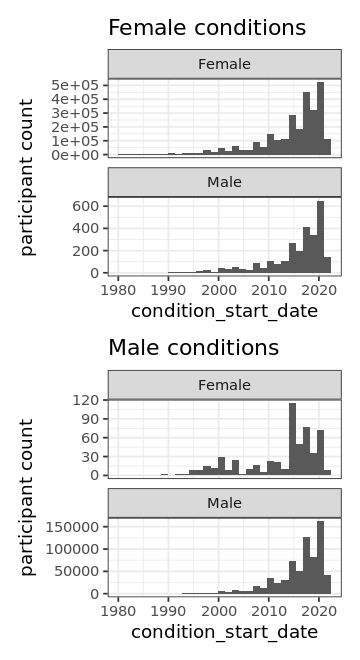

In [208]:
options(repr.plot.width=3, repr.plot.height=5.5)
g1/g2
pdf('output/tempora_spread.pdf',w=3,h=5.5);g1/g2;dev.off()